# Automated Post-Data Analasis for Mollweide plots

In [1]:
from scipy.io import loadmat
import astropy.units as units
import astropy.coordinates as coord
import numpy as np
import glob
import os
import fnmatch
import natsort
import matplotlib.pyplot as plt

In [2]:
# string preparation
simDir = '/Users/yiqianqian/Library/Mobile Documents/com~apple~CloudDocs/Research/PulsarTiming/SimDATA/MultiSource/Investigation/Final/realizations/2bands/simData/Band_opt_diff/'
estDir = '/Users/yiqianqian/Library/Mobile Documents/com~apple~CloudDocs/Research/PulsarTiming/SimDATA/MultiSource/Investigation/Final/realizations/2bands/results_diff_opt_iMBLT/'
files = [f for f in os.listdir(simDir)]
rlzFiles = []
for f in files:
   if fnmatch.fnmatch(f, 'GWBsimDataSKASrlz[1-5]Nrlz1.mat'):
       rlzFiles.append(f)

rlzFiles = sorted(rlzFiles)
print(rlzFiles)

rlzBaseName = [f.strip('.mat') for f in rlzFiles]
print(rlzBaseName)

['GWBsimDataSKASrlz1Nrlz1.mat', 'GWBsimDataSKASrlz2Nrlz1.mat', 'GWBsimDataSKASrlz3Nrlz1.mat', 'GWBsimDataSKASrlz4Nrlz1.mat', 'GWBsimDataSKASrlz5Nrlz1.mat']
['GWBsimDataSKASrlz1Nrlz1', 'GWBsimDataSKASrlz2Nrlz1', 'GWBsimDataSKASrlz3Nrlz1', 'GWBsimDataSKASrlz4Nrlz1', 'GWBsimDataSKASrlz5Nrlz1']


# Use only one set of results only, i.e. no cross correlation between different sets of results

In [ ]:
snr_threshold = 7
tSNR = 5  # SNR cut for true sources
NMTC_t = 0.70
methods = 'iMBLT'
freq_err = []
snr_err = []
ra_err = []
dec_err = []
matched_snr_mult = []

for rlz in range(len(rlzFiles)):
    repSrc = loadmat(estDir + rlzBaseName[rlz] + '/repSrc_sky' + str(
        snr_threshold) + 'tSNR_' + str(tSNR) + '_NMTC' + str(NMTC_t) + '.mat')
    cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky' + str(
        snr_threshold) + 'tSNR_' + str(tSNR) + '_NMTC' + str(NMTC_t) + '.mat')
    matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky' + str(
        snr_threshold) + 'tSNR_' + str(tSNR) + '_NMTC' + str(NMTC_t) + '.mat')
    simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky' + str(
        snr_threshold) + 'tSNR_' + str(tSNR) + '_NMTC' + str(NMTC_t) + '.mat')
    # assign variables
    repRA = repSrc['repRA']
    repDec = repSrc['repDec']
    repSNR = repSrc['repSNR']
    repFreq = repSrc['repFreq']
    cnfrmRA = cfrSrc['cnfrmRA']
    cnfrmDec = cfrSrc['cnfrmDec']
    cnfrmSNR = cfrSrc['cnfrmSNR']
    cnfrmFreq = cfrSrc['cnfrmFreq']
    matRA = matSrc['matched_alpha_rep']
    matDec = matSrc['matched_dec_rep']
    matSNR = matSrc['matched_snr_rep']
    matFreq = matSrc['matched_freq_rep']

    matRA_cnfrm = matSrc['matched_alpha']
    matDec_cnfrm = matSrc['matched_dec']
    matSNR_cnfrm = matSrc['matched_snr']
    matFreq_cnfrm = matSrc['matched_freq']

    simRA_nm = simSrc_nm['simRA_nm']
    simDec_nm = simSrc_nm['simDec_nm']

    # create detection rate reports
    detection_rate = cnfrmDec.size / repDec.size
    min_snr = min(repSNR[0])
    with open(estDir + 'fig/' + 'detection_rate.txt', 'a') as f:
        f.write(
            methods + f': Uses SNR cut {snr_threshold} and true sources above SNR {tSNR}, {rlzBaseName[rlz]} reported {len(repSNR[0])} sources, confirmed {len(cnfrmSNR[0])} sources, the detection rate is {len(cnfrmSNR[0])/ len(repSNR[0])}, lowest reported SNR is {min(repSNR[0])}, the lowest confirmed SNR is {min(cnfrmSNR[0])}')
        f.write('\n')

    # plot Mollweide projections
    fig = plt.figure(figsize=(12, 8), dpi=200)
    ax = fig.add_subplot(111, projection='mollweide')
    xlab = ['14h', '16h', '18h', '20h', '22h',
            '0h', '2h', '4h', '6h', '8h', '10h']

    alpha_rep = coord.Angle(
        repRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_cnfrm = coord.Angle(
        cnfrmRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_mat = coord.Angle(
        matRA_cnfrm * units.rad).wrap_at(180 * units.degree).radian
    alpha_sim_nm = coord.Angle(
        simRA_nm * units.rad).wrap_at(180 * units.degree).radian

    f1 = ax.scatter(alpha_sim_nm, simDec_nm, label='True Source',
                    zorder=1, color='lightsteelblue')
    f2 = ax.scatter(alpha_rep, repDec, c=repSNR, cmap='YlGnBu', marker='^', s=60, edgecolor='k',
                    lw=.25, label='Reported Source', zorder=2)    # using up triangle for reported sources
    f3 = ax.scatter(alpha_cnfrm, cnfrmDec, marker='*', s=40, edgecolor='r', facecolor='r',
                    label='Confirmed Source', lw=0.5, zorder=4)  # star for   confirmed sources
    f4 = ax.scatter(alpha_mat, matDec_cnfrm, c=matSNR_cnfrm, cmap='YlGnBu', marker='s',
                    edgecolor='k', label='Matched True', alpha=0.7, zorder=3)  # square for matched true sources

    for i in range(len(cnfrmRA[0])):
        plt.plot([alpha_cnfrm[0][i], alpha_mat[0][i]], [cnfrmDec[0][i], matDec_cnfrm[0][i]], ls='--', lw=1, color='C4', alpha=0.5,
                 zorder=0)

    ax.set_xticklabels(xlab)
    ax.set_title(rlzBaseName[rlz])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\delta$')
    ax.grid(True)
    fig.colorbar(f2, shrink=0.8, label='SNR')
    ax.legend(bbox_to_anchor=(1.0, .05))
    # fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide' + str(snr_threshold) + '.png',dpi=300,facecolor='white')
    fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_SNR' + str(
        snr_threshold) + 'tSNR_' + str(tSNR) + '.png', dpi=300, facecolor='white', bbox_inches='tight')

    # compute the error for frequency, SNR, RA & DEC
    freq_error = (np.abs(matFreq_cnfrm - cnfrmFreq)/matFreq_cnfrm) * 100
    snr_error = (np.abs(matSNR_cnfrm - cnfrmSNR)/matSNR_cnfrm) * 100
    ra_error = (np.abs(matRA_cnfrm - cnfrmRA)/matRA_cnfrm) * 100
    dec_error = (np.abs(matDec_cnfrm - cnfrmDec)/np.abs(matDec_cnfrm)) * 100
    freq_err.append(freq_error)
    snr_err.append(snr_error)
    ra_err.append(ra_error)
    dec_err.append(dec_error)
    matched_snr_mult.append(matSNR_cnfrm)


In [ ]:
# Generate Error plots
fig = plt.figure(figsize=(12,8),dpi=200)
ax1 = fig.add_subplot(2,2,1)
for rlz in range(len(rlzFiles)):
    ax1.scatter(matched_snr_mult[rlz],freq_err[rlz], label='Srlz'+str(rlz+1))
ax1.set_title('Freq. Error')
ax1.set_xlabel('SNR')
ax1.set_ylabel('Error[%]')
ax1.legend()
# ax1.label_outer() # Hide x labels and tick labels for top plots and y ticks for right plots.

ax2 = fig.add_subplot(2,2,2)
for rlz in range(len(rlzFiles)):
    ax2.scatter(matched_snr_mult[rlz], snr_err[rlz])
ax2.set_title('SNR Error')
ax2.set_xlabel('SNR')
ax2.set_ylabel('Error [%]')
# ax2.label_outer()


ax3 = fig.add_subplot(2,2,3)
for rlz in range(len(rlzFiles)):
    ax3.scatter(matched_snr_mult[rlz], ra_err[rlz])
ax3.set_title('RA Error')
ax3.set_xlabel('SNR')
ax3.set_ylabel('Error[%]')
# ax3.label_outer()

ax4 = fig.add_subplot(2,2,4)
for rlz in range(len(rlzFiles)):
    ax4.scatter(matched_snr_mult[rlz], dec_err[rlz])
ax4.set_title('DEC Error')
ax4.set_xlabel('SNR')
ax4.set_ylabel('Error[%]')
# ax4.label_outer()

plt.tight_layout()
# fig.savefig(estDir + 'fig/' + '/Error' + str(snr_threshold) + '.png',dpi=300,facecolor='white')

# Use one band, xMBLT and iMBLT results to eliminate spurious sources

## Terminology
SDM:
>
Confirmed sources only appear when true sources are brought into the picture. Only reported sources should be tested for match 
with true sources. Identified sources are the initial output from the iterative pipeline.

This is different from my naming of the variables, but when plotting the figures, the label is refered to this terminology.
Map from my naming to SDM's convention: confirmed sources -> reported sources; estimated sources -> identified sources; identified sources -> confirmed sources.

In [14]:
# Setting up parameters
SNR_threshold = None
tSNR_cut = 5
eSNR = 7
psr_t = 0.9
NMTC_t = 0.65
dataset = 'xMBLT' # use 'Est' for one band + xMBLT/iMBLT, 'xMBLT' for xMBLT + iMBLT

## Fig 1

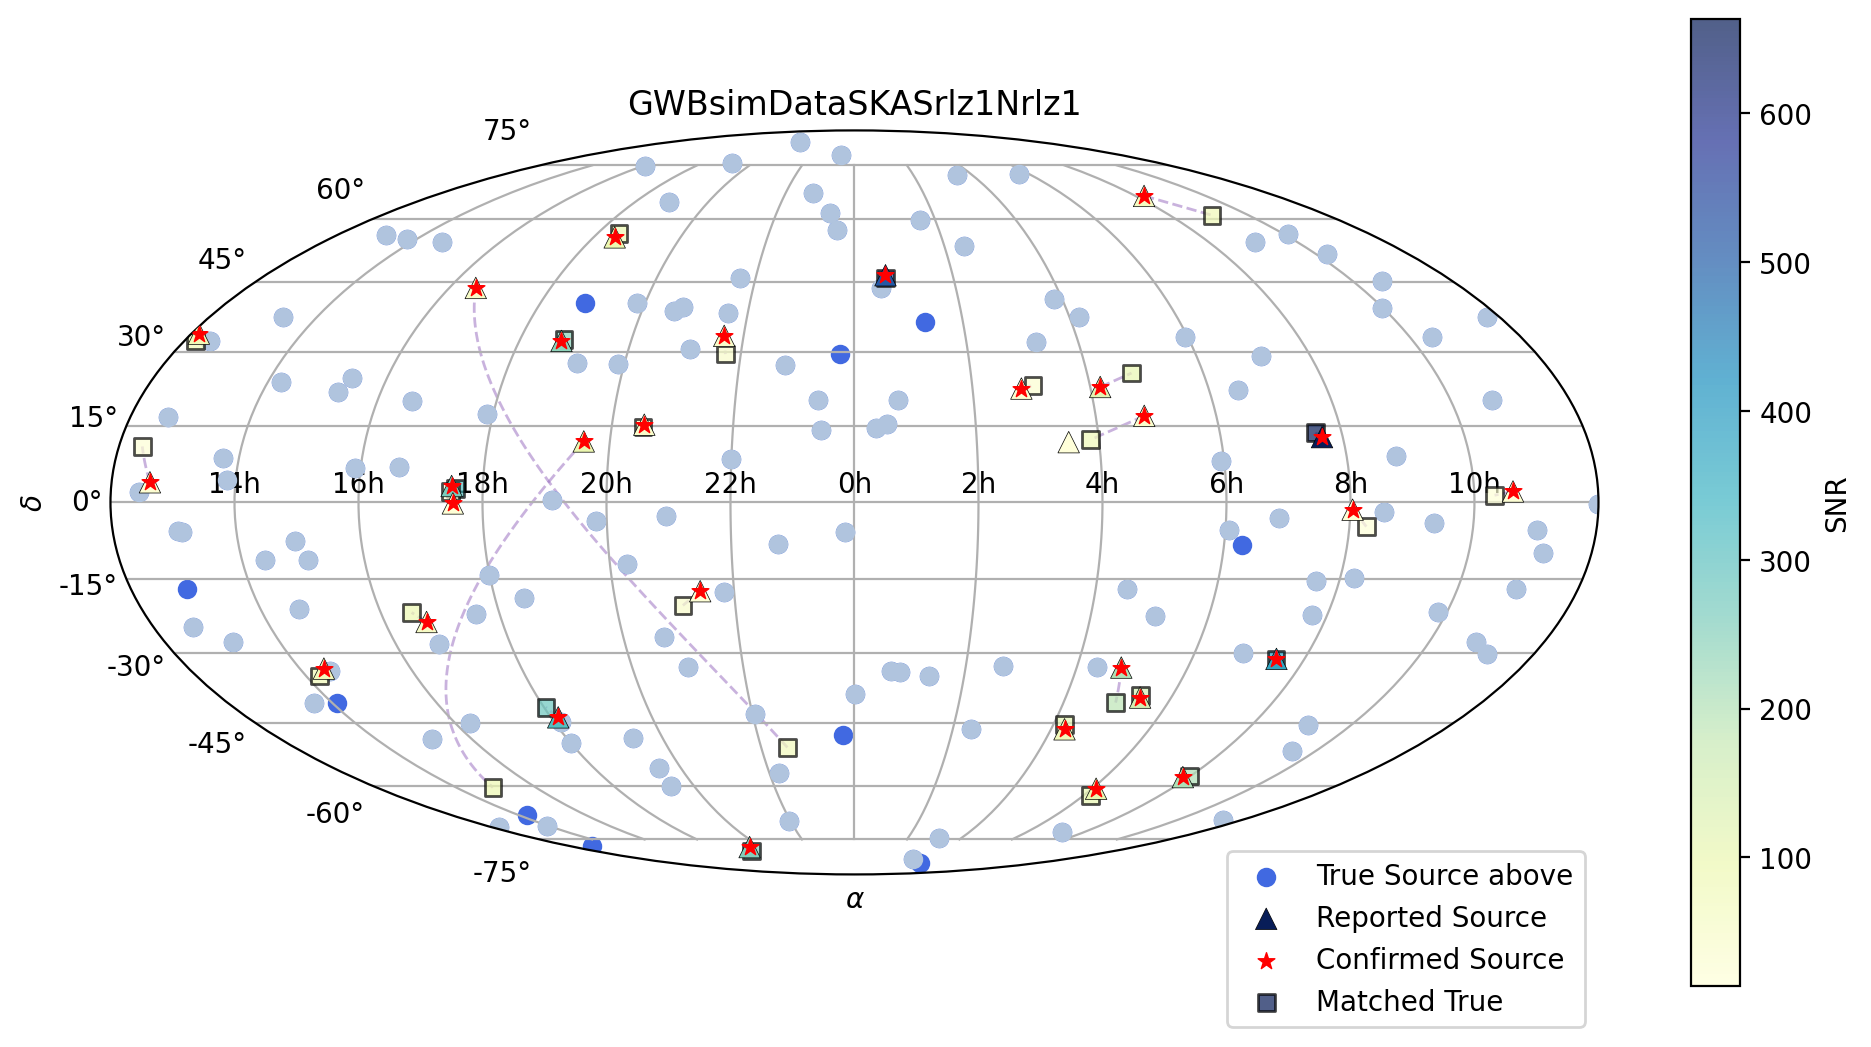

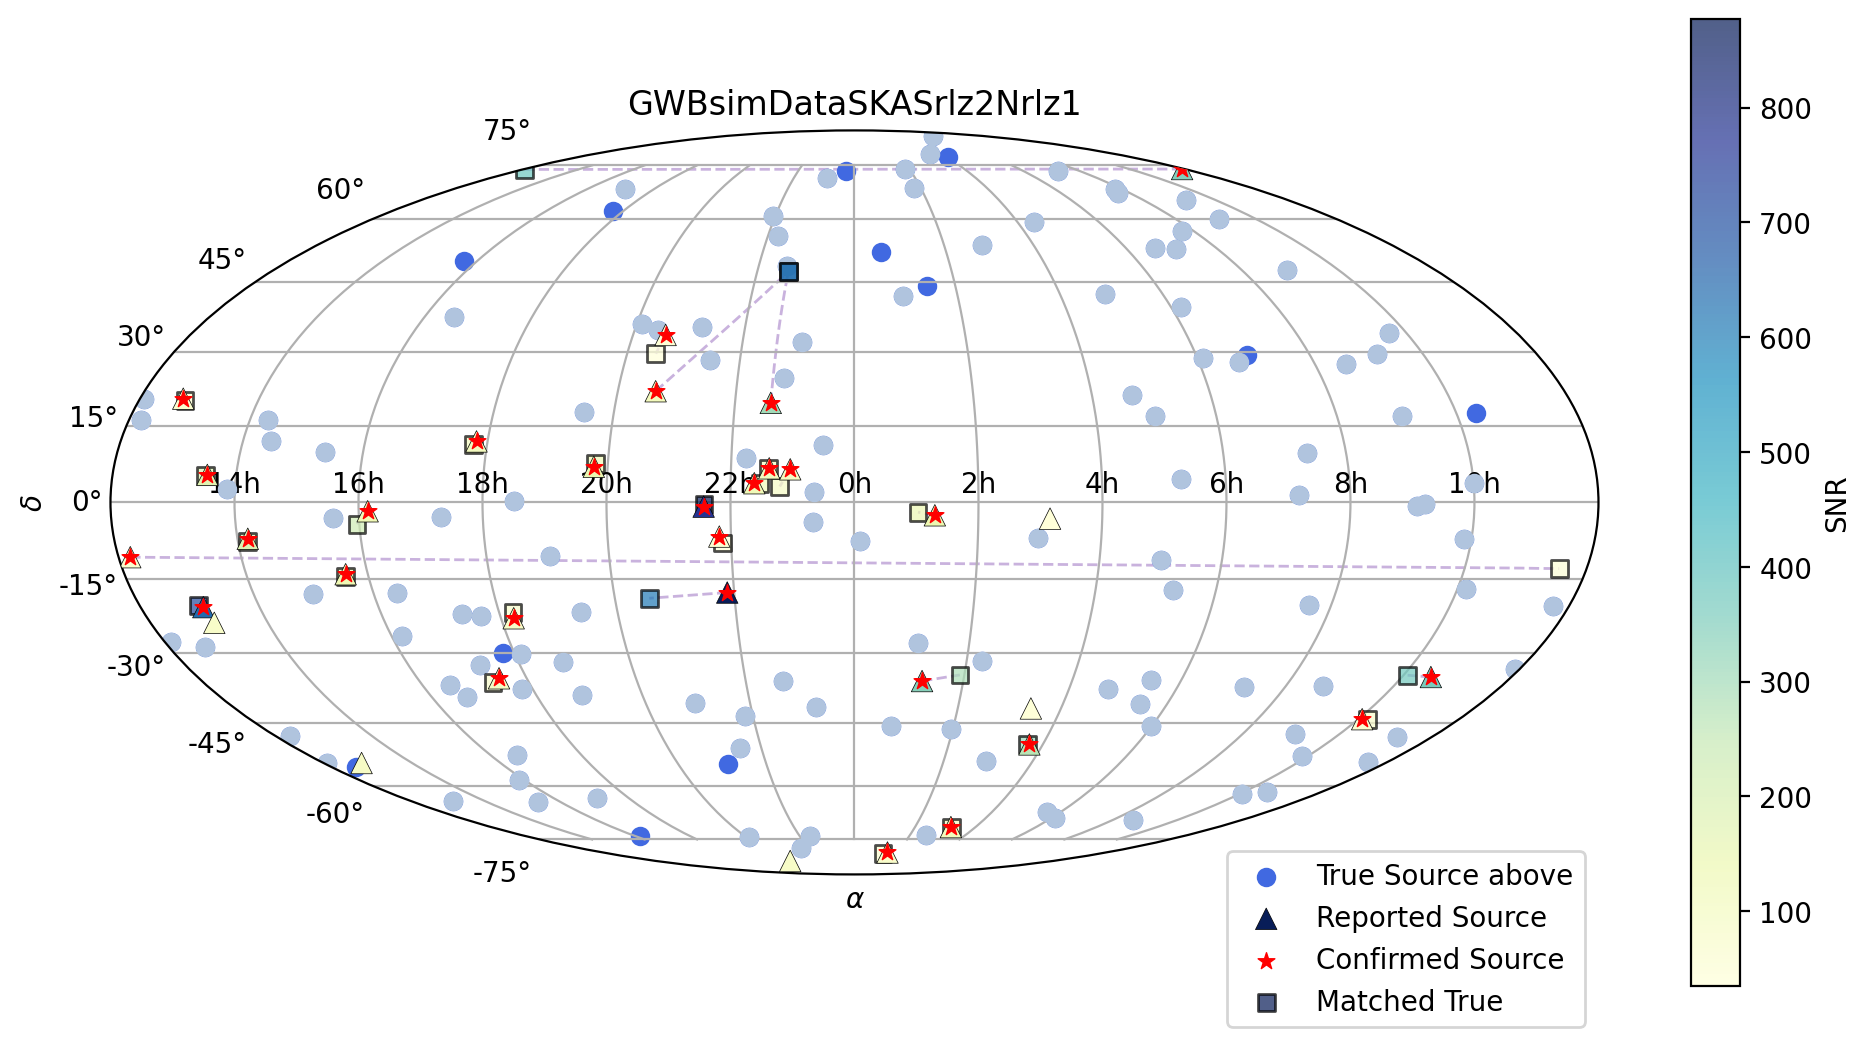

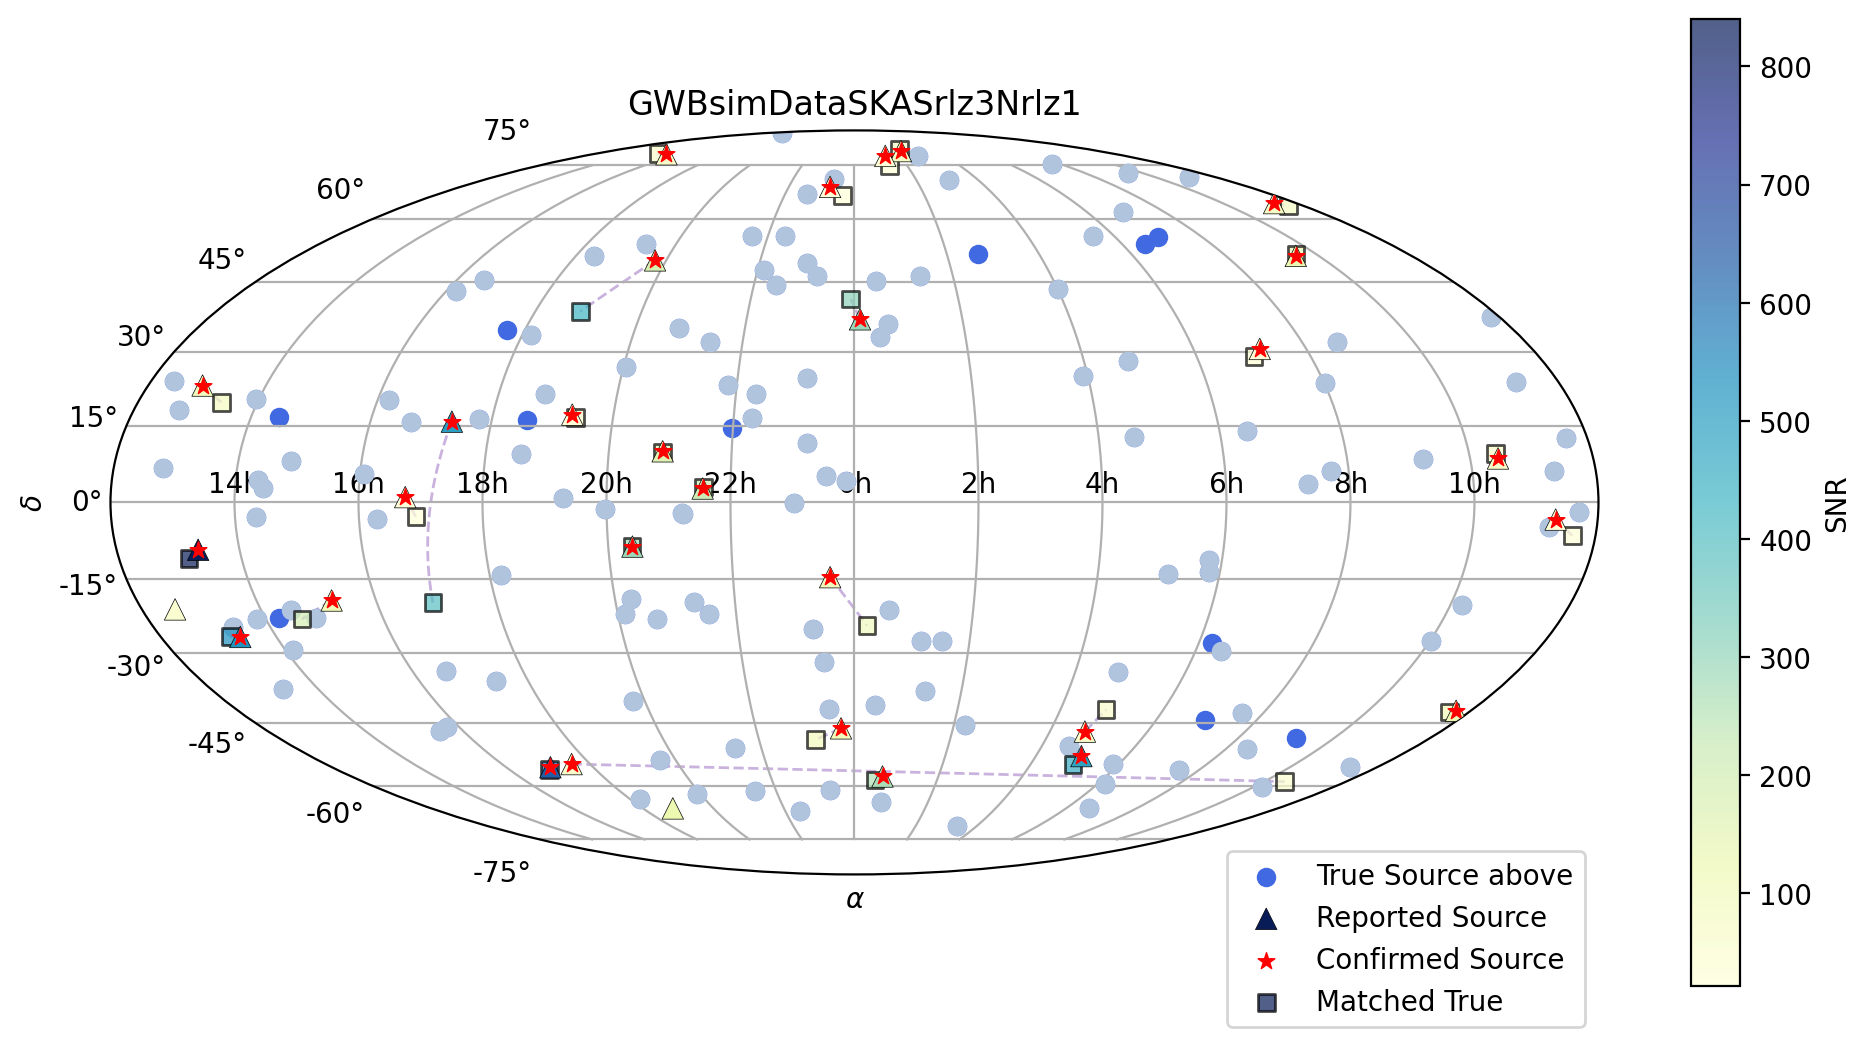

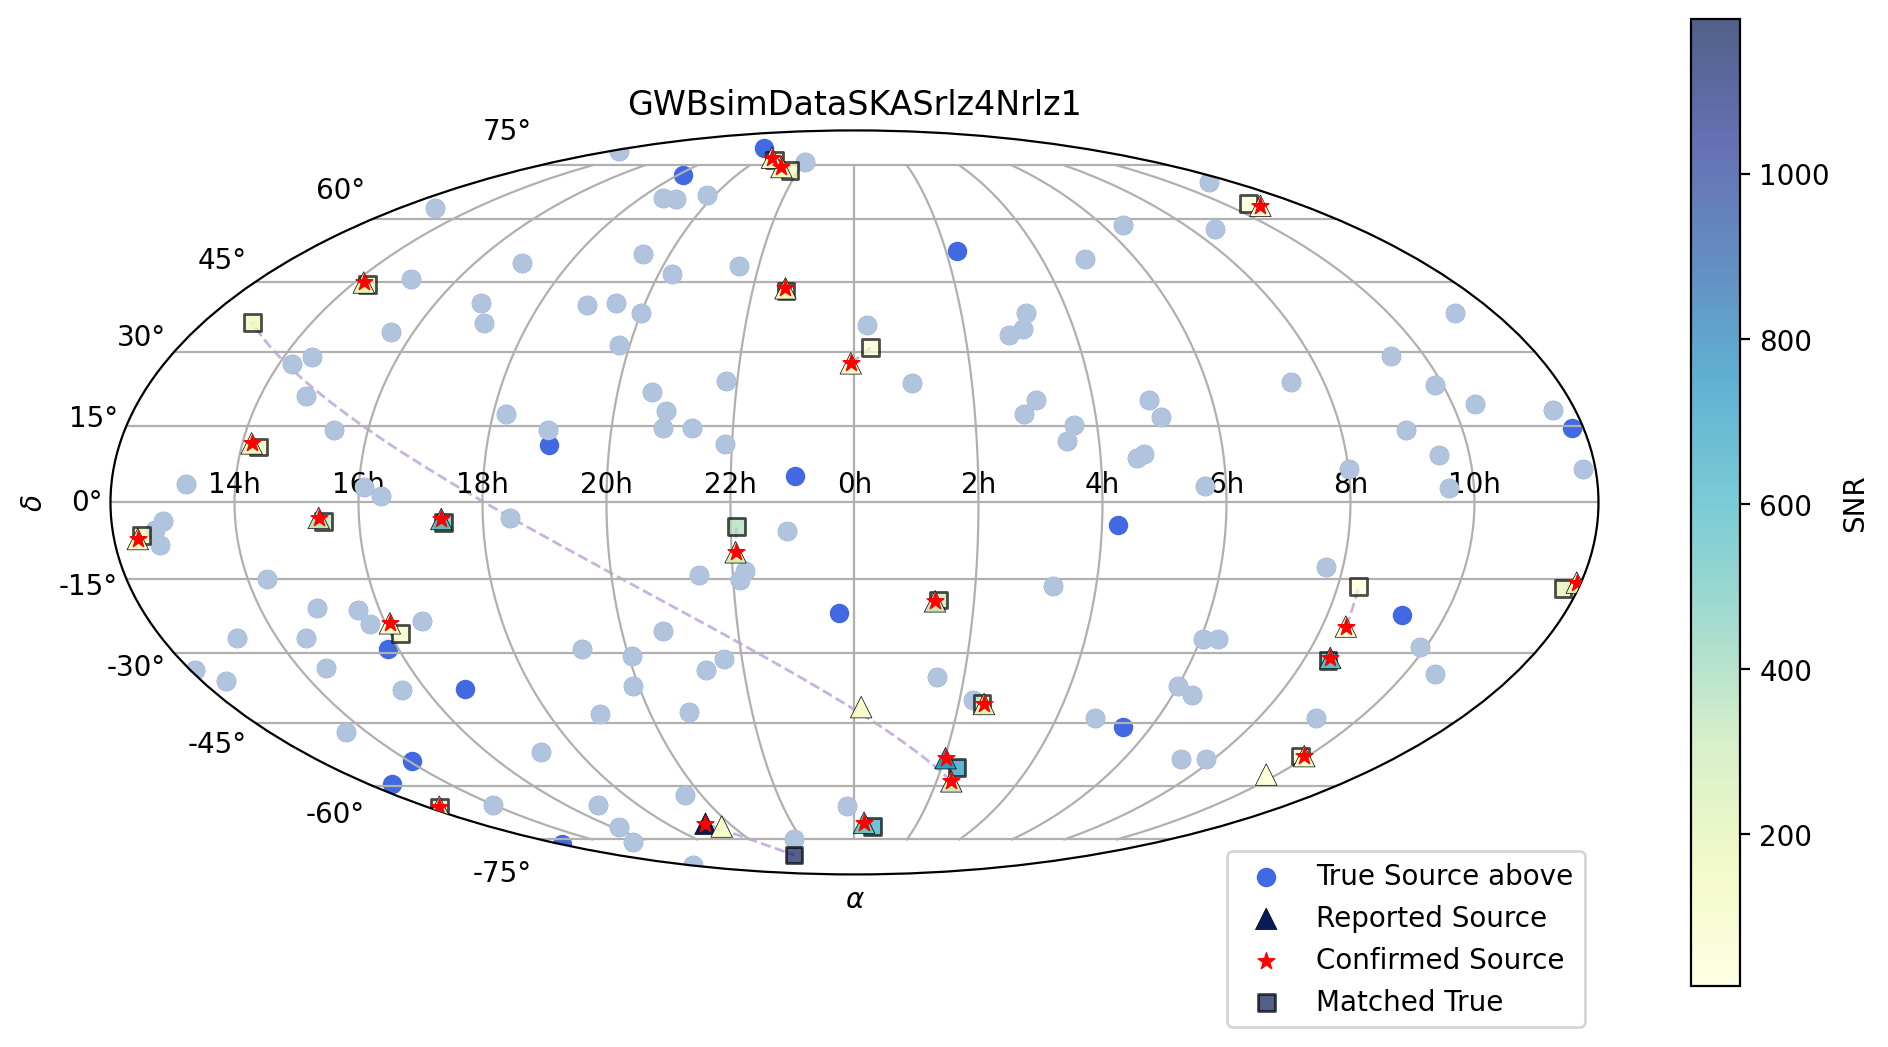

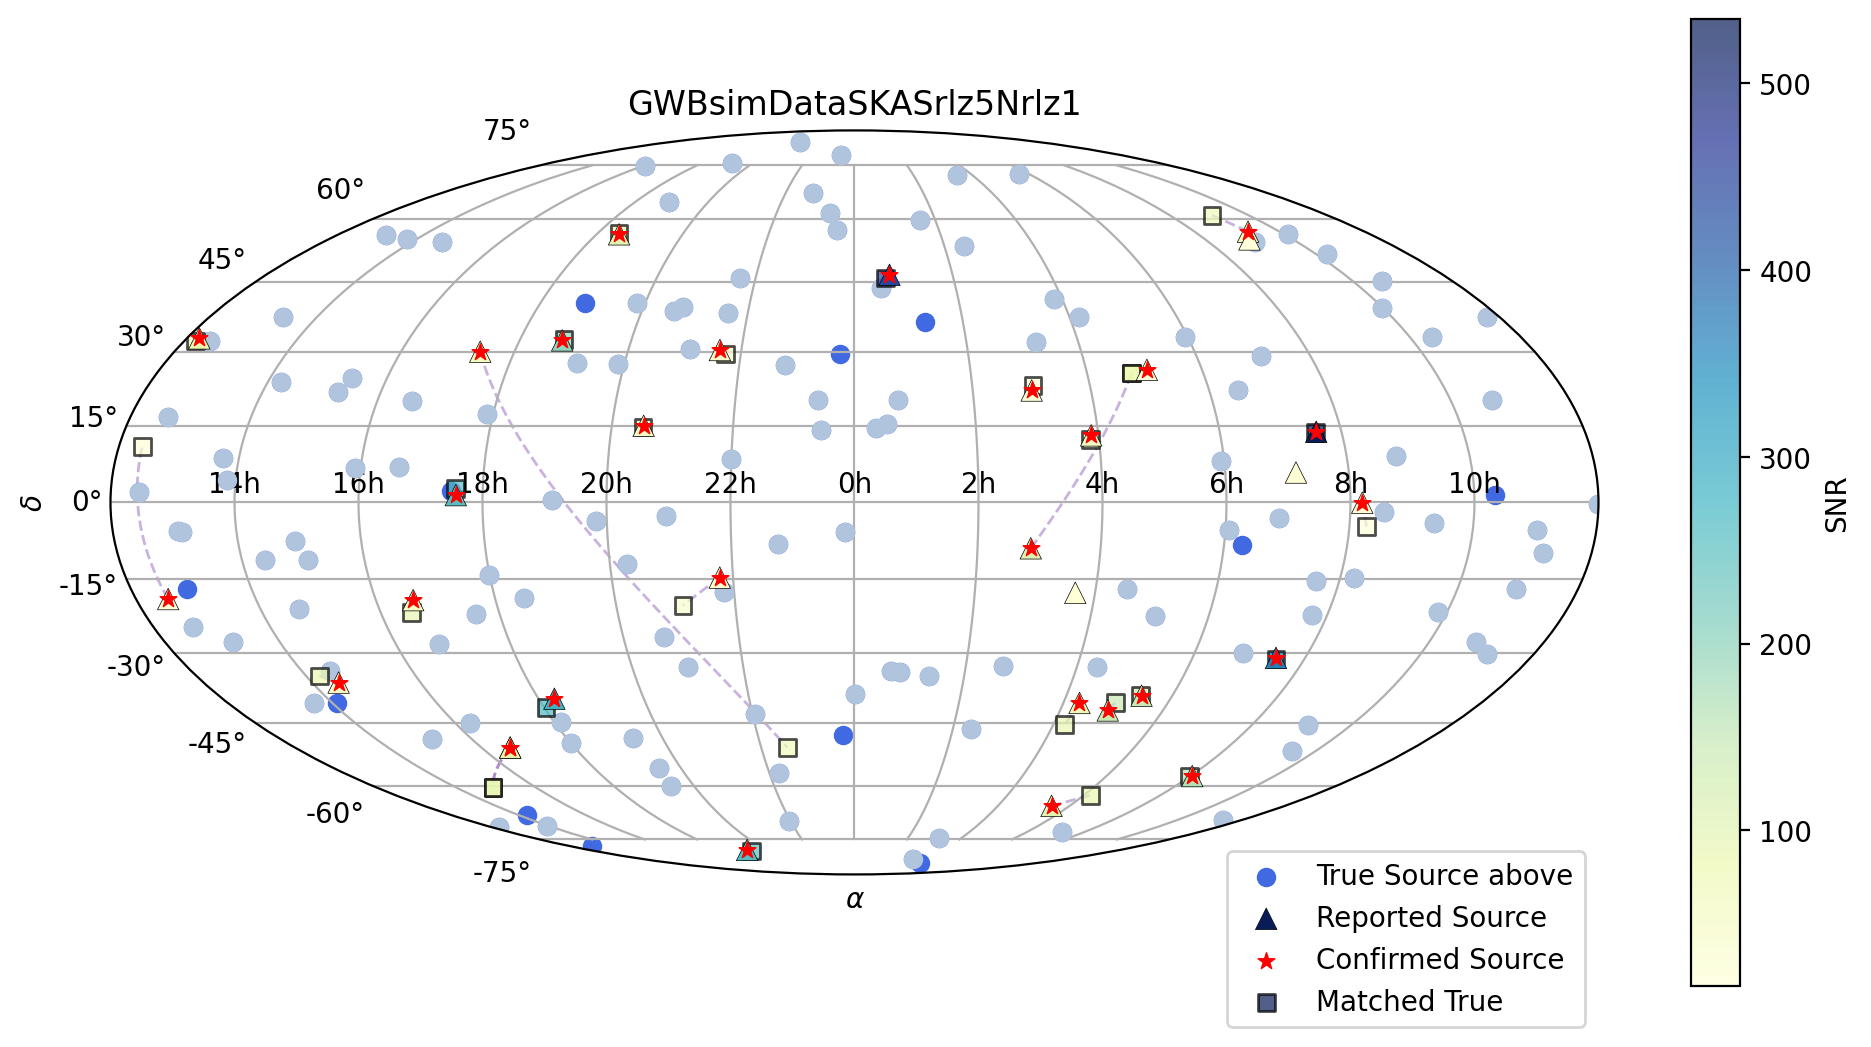

In [15]:
freq_err = []
snr_err = []
ra_err = []
dec_err = []
matched_snr_mult = []

freq_err_id = []
snr_err_id = []
ra_err_id = []
dec_err_id = []
matched_snr_mult_id = []
idRA_mult = []
matRA_id_mult = []
idDec_mult = []
matDec_id_mult = []

for rlz in range(len(rlzFiles)):
    # Use all true sources
    # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')

    # Use filltered true sources and filterd identified sources
    # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
    # cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
    # matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
    # simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')

    # Use filtered true sources and all identified sources
    idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_' + dataset  + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
    cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_' + dataset  + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
    matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_' + dataset  + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
    simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_' + dataset + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')

    # assign variables
    idRA = idSrc['idRA']
    idDec = idSrc['idDec']
    idSNR = idSrc['idSNR']
    idFreq = idSrc['idFreq']
    cnfrmRA = cfrSrc['cnfrmRA']
    cnfrmDec = cfrSrc['cnfrmDec']
    cnfrmSNR = cfrSrc['cnfrmSNR']
    cnfrmFreq = cfrSrc['cnfrmFreq']
    matRA = matSrc['matched_alpha_cnfrm']
    matDec = matSrc['matched_dec_cnfrm']
    matSNR = matSrc['matched_snr_cnfrm']
    matFreq = matSrc['matched_freq_cnfrm']

    matRA_id = matSrc['matched_alpha']
    matDec_id = matSrc['matched_dec']
    matSNR_id = matSrc['matched_snr']
    matFreq_id = matSrc['matched_freq']
    simRA_nm = simSrc_nm['simRA_nm']
    simDec_nm = simSrc_nm['simDec_nm']
    simSNR_nm = simSrc_nm['simSNR_nm']

    # create detection rate reports
    detection_rate = idDec.size / cnfrmDec.size
    min_snr = min(cnfrmSNR[0])
    with open(estDir + 'fig/' + 'detection_rate_' + dataset + '.txt','a') as f:
        f.write(f'Using SNR cut off {SNR_threshold}, true source SNR cut {tSNR_cut}, per-pulsar NMTC threshold {psr_t} and estimated SNR cut {eSNR}, confirmation NMTC {NMTC_t}, {rlzBaseName[rlz]} reported {len(cnfrmSNR[0])} sources, confirmed {len(idSNR[0])} sources, the detection rate is {detection_rate}, lowest reported SNR is {min_snr}, the lowest confirmed SNR is {min(idSNR[0])}\n')
    
    # plot Mollweide projections
    fig = plt.figure(figsize=(12,8),dpi=200)
    ax = fig.add_subplot(111, projection='mollweide')
    xlab = ['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h']

    alpha_id = coord.Angle(idRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_cnfrm = coord.Angle(cnfrmRA * units.rad).wrap_at(180 * units.degree).radian
    # alpha_mat = coord.Angle(matRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_mat_id = coord.Angle(matRA_id * units.rad).wrap_at(180 * units.degree).radian # true sources matched to confirmed sources
    alpha_sim_nm = coord.Angle(simRA_nm * units.rad).wrap_at(180 * units.degree).radian

    f1 = ax.scatter(alpha_sim_nm,simDec_nm,label='True Source above', color='royalblue', zorder=1)
    f0 = ax.scatter(alpha_sim_nm[simSNR_nm < min(cnfrmSNR[0])], simDec_nm[simSNR_nm < min(cnfrmSNR[0])], color='lightsteelblue', zorder=2)
    f2 = ax.scatter(alpha_cnfrm,cnfrmDec,c=cnfrmSNR,cmap='YlGnBu',marker='^',s=60,edgecolor='k',lw=.25,label='Reported Source', zorder=3)    # using up triangle for reported sources
    f3 = ax.scatter(alpha_id,idDec,marker='*',s=40, edgecolor='r', facecolor='r',label='Confirmed Source', lw=0.5, zorder=4) # star for   confirmed sources
    f4 = ax.scatter(alpha_mat_id,matDec_id,c=matSNR_id,cmap='YlGnBu',marker='s',edgecolor='k', label='Matched True',alpha=0.7, zorder=2) #  square for matched true sources

    for i in range(len(idRA[0])):
        plt.plot([alpha_id[0][i], alpha_mat_id[0][i]],[idDec[0][i], matDec_id[0][i]], ls='--', lw=1, color = 'C4', alpha=0.5,
        zorder=0)

    ax.set_xticklabels(xlab)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\delta$')
    ax.set_title(rlzBaseName[rlz])
    ax.grid(True)
    fig.colorbar(f4,shrink=0.8, label='SNR')
    ax.legend(bbox_to_anchor=(1.0,.05))
    # fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_Est_SNR' + str(SNR_threshold) + '.png', dpi=300, facecolor='white')
    # fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')
    fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_' + dataset + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')


    # compute the error for frequency, SNR, RA & DEC
    freq_error_id = (np.abs(matFreq_id - idFreq)/matFreq_id) * 100
    snr_error_id = (np.abs(matSNR_id - idSNR)/matSNR_id) * 100
    ra_error_id = (np.abs(matRA_id - idRA)/matRA_id) * 100
    dec_error_id = (np.abs(matDec_id - idDec)/np.abs(matDec_id)) * 100
    freq_err_id.append(freq_error_id)
    snr_err_id.append(snr_error_id)
    ra_err_id.append(ra_error_id)
    dec_err_id.append(dec_error_id)
    matched_snr_mult_id.append(matSNR_id)
    idRA_mult.append(idRA)
    idDec_mult.append(idDec)
    matRA_id_mult.append(matRA_id)
    matDec_id_mult.append(matDec_id)

In [ ]:
# Plot all Mollweide plots into one figure for 6 source realizations

# plot Mollweide projections
fig, axes = plt.subplots(2, 3, figsize=(16, 9), dpi=200, subplot_kw={'projection': 'mollweide'})
fig.subplots_adjust(top=0.9, bottom=0.35, hspace=0)
for rlz, ax in enumerate(axes.flat):
    print(rlz, ax)
    # Use all true sources
    # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_Est_SNR' + str(SNR_threshold) + '.mat')
    # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')

    # Use filltered true sources and filterd identified sources
    # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
    # cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
    # matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
    # simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')

    # Use filtered true sources and all identified sources
    idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_' + dataset  + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
    cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_' + dataset  + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
    matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_' + dataset  + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
    simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_' + dataset + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')

    # assign variables
    idRA = idSrc['idRA']
    idDec = idSrc['idDec']
    idSNR = idSrc['idSNR']
    idFreq = idSrc['idFreq']
    cnfrmRA = cfrSrc['cnfrmRA']
    cnfrmDec = cfrSrc['cnfrmDec']
    cnfrmSNR = cfrSrc['cnfrmSNR']
    cnfrmFreq = cfrSrc['cnfrmFreq']
    matRA = matSrc['matched_alpha_cnfrm']
    matDec = matSrc['matched_dec_cnfrm']
    matSNR = matSrc['matched_snr_cnfrm']
    matFreq = matSrc['matched_freq_cnfrm']

    matRA_id = matSrc['matched_alpha']
    matDec_id = matSrc['matched_dec']
    matSNR_id = matSrc['matched_snr']
    matFreq_id = matSrc['matched_freq']
    simRA_nm = simSrc_nm['simRA_nm']
    simDec_nm = simSrc_nm['simDec_nm']
    simSNR_nm = simSrc_nm['simSNR_nm']

    # create detection rate reports
    detection_rate = idDec.size / cnfrmDec.size
    min_snr = min(cnfrmSNR[0])

    xlab = ['14h', '16h', '18h', '20h', '22h',
            '0h', '2h', '4h', '6h', '8h', '10h']

    alpha_id = coord.Angle(idRA * units.rad).wrap_at(180 * units.degree).radian
    alpha_cnfrm = coord.Angle(
        cnfrmRA * units.rad).wrap_at(180 * units.degree).radian
    # alpha_mat = coord.Angle(matRA * units.rad).wrap_at(180 * units.degree).radian
    # true sources matched to confirmed sources
    alpha_mat_id = coord.Angle(
        matRA_id * units.rad).wrap_at(180 * units.degree).radian
    alpha_sim_nm = coord.Angle(
        simRA_nm * units.rad).wrap_at(180 * units.degree).radian

    f1 = ax.scatter(
        alpha_sim_nm, simDec_nm, label='True Source above', color='royalblue', s=13, zorder=1)
    f0 = ax.scatter(alpha_sim_nm[simSNR_nm < min(
        cnfrmSNR[0])], simDec_nm[simSNR_nm < min(cnfrmSNR[0])], color='lightsteelblue', s=13, zorder=2)
    f2 = ax.scatter(alpha_cnfrm, cnfrmDec, c=cnfrmSNR, cmap='YlGnBu', marker='^', s=25,
                                edgecolor='k', lw=.25, label='Reported Source', zorder=3)    # using up triangle for reported sources
    f3 = ax.scatter(alpha_id, idDec, marker='*', s=10, edgecolor='r', facecolor='r',
                                label='Confirmed Source', lw=0.5, zorder=4)  # star for   confirmed sources
    f4 = ax.scatter(alpha_mat_id, matDec_id, c=matSNR_id, cmap='YlGnBu', marker='s', s=20,
                                edgecolor='k', label='Matched True', alpha=0.7, zorder=2)  # square for matched true sources

    for i in range(len(idRA[0])):
        ax.plot([alpha_id[0][i], alpha_mat_id[0][i]], [idDec[0][i], matDec_id[0][i]], ls='--', lw=.5, color='C4', alpha=0.5,
                 zorder=0)
    if rlz == 0:
        ax.set_xlabel(r'$\alpha$')
        ax.set_ylabel(r'$\delta$')
    else:
        ax.set_yticklabels([])

    ax.set_xticklabels(xlab,fontsize=8)
    # ax.set_title(rlzBaseName[rlz])
    ax.grid(True)
    # fig.colorbar(f4,shrink=0.8, label='SNR')
    # ax.legend(bbox_to_anchor=(1.0,.05))
    
# fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_Est_SNR' + str(SNR_threshold) + '.png', dpi=300, facecolor='white')
# fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(estDir + 'fig/' + '/MollWeide_Together' + dataset + 'tSNR_' + str(
        tSNR_cut) + '+_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')


In [ ]:
# Plot all Mollweide plots into one figure for 6 source realizations in 3X1 format

# plot Mollweide projections
# Generate 2 3X1 figs
for figs in range(2):
    fig, axes = plt.subplots(3, 1, figsize=(9, 12), dpi=200,
                             subplot_kw={'projection': 'mollweide'})
    fig.subplots_adjust(top=0.9, bottom=0.35, right = 0.8 ,hspace=0.2)
    for rlz, ax in enumerate(axes.flat):
        print(rlz, ax)
        # Use all true sources
        # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
        # cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
        # matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')
        # simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_Est_SNR' + str(SNR_threshold) + '.mat')
        # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_Est_SNR' + str(SNR_threshold) + '.mat')

        # Use filltered true sources and filterd identified sources
        # idSrc = loadmat(estDir + rlzBaseName[rlz] + '/idSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
        # cfrSrc = loadmat(estDir + rlzBaseName[rlz] + '/cnfrmSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
        # matSrc = loadmat(estDir + rlzBaseName[rlz] + '/matSrc_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')
        # simSrc_nm = loadmat(estDir + rlzBaseName[rlz] + '/simSrc_nm_sky_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.mat')

        # Use filtered true sources and all identified sources
        idSrc = loadmat(estDir + rlzBaseName[3*figs+rlz] + '/idSrc_sky_' + dataset + 'tSNR_' + str(
            tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
        cfrSrc = loadmat(estDir + rlzBaseName[3*figs+rlz] + '/cnfrmSrc_sky_' + dataset + 'tSNR_' + str(
            tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
        matSrc = loadmat(estDir + rlzBaseName[3*figs+rlz] + '/matSrc_sky_' + dataset + 'tSNR_' + str(
            tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')
        simSrc_nm = loadmat(estDir + rlzBaseName[3*figs+rlz] + '/simSrc_nm_sky_' + dataset + 'tSNR_' + str(
            tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.mat')

        # assign variables
        idRA = idSrc['idRA']
        idDec = idSrc['idDec']
        idSNR = idSrc['idSNR']
        idFreq = idSrc['idFreq']
        cnfrmRA = cfrSrc['cnfrmRA']
        cnfrmDec = cfrSrc['cnfrmDec']
        cnfrmSNR = cfrSrc['cnfrmSNR']
        cnfrmFreq = cfrSrc['cnfrmFreq']
        matRA = matSrc['matched_alpha_cnfrm']
        matDec = matSrc['matched_dec_cnfrm']
        matSNR = matSrc['matched_snr_cnfrm']
        matFreq = matSrc['matched_freq_cnfrm']
        matRA_id = matSrc['matched_alpha']
        matDec_id = matSrc['matched_dec']
        matSNR_id = matSrc['matched_snr']
        matFreq_id = matSrc['matched_freq']
        simRA_nm = simSrc_nm['simRA_nm']
        simDec_nm = simSrc_nm['simDec_nm']
        simSNR_nm = simSrc_nm['simSNR_nm']

        # create detection rate reports
        detection_rate = idDec.size / cnfrmDec.size
        min_snr = min(cnfrmSNR[0])

        xlab = ['14h', '16h', '18h', '20h', '22h',
                '0h', '2h', '4h', '6h', '8h', '10h']

        alpha_id = coord.Angle(
            idRA * units.rad).wrap_at(180 * units.degree).radian
        alpha_cnfrm = coord.Angle(
            cnfrmRA * units.rad).wrap_at(180 * units.degree).radian
        # alpha_mat = coord.Angle(matRA * units.rad).wrap_at(180 * units.degree).radian
        # true sources matched to confirmed sources
        alpha_mat_id = coord.Angle(
            matRA_id * units.rad).wrap_at(180 * units.degree).radian
        alpha_sim_nm = coord.Angle(
            simRA_nm * units.rad).wrap_at(180 * units.degree).radian

        f1 = ax.scatter(
            alpha_sim_nm, simDec_nm, label='True Source above', color='royalblue', s=13, zorder=1)
        f0 = ax.scatter(alpha_sim_nm[simSNR_nm < min(
            cnfrmSNR[0])], simDec_nm[simSNR_nm < min(cnfrmSNR[0])], color='silver', s=13, zorder=2)
        f2 = ax.scatter(alpha_cnfrm, cnfrmDec, c=cnfrmSNR, cmap='YlGnBu', marker='^', s=25,
                        edgecolor='k', lw=.25, label='Reported Source', zorder=3)    # using up triangle for reported sources
        f3 = ax.scatter(alpha_id, idDec, marker='*', s=10, edgecolor='r', facecolor='r',
                        label='Confirmed Source', lw=0.5, zorder=4)  # star for   confirmed sources
        f4 = ax.scatter(alpha_mat_id, matDec_id, c=matSNR_id, cmap='YlGnBu', marker='s', s=20,
                        edgecolor='k', label='Matched True', alpha=0.7, zorder=2)  # square for matched true sources

        for i in range(len(idRA[0])):
            ax.plot([alpha_id[0][i], alpha_mat_id[0][i]], [idDec[0][i], matDec_id[0][i]], ls='--', lw=.5, color='C4', alpha=0.5,
                    zorder=0)
            if rlz == 0:
                ax.set_xlabel(r'$\alpha$')
                ax.set_ylabel(r'$\delta$')
                ax.set_xticklabels(xlab, fontsize=8)
            else:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
        fig.colorbar(f4,ax=ax)
        # ax.set_title(rlzBaseName[rlz])
        ax.grid(True)
        # fig.colorbar(f4,shrink=0.8, label='SNR')
        # ax.legend(bbox_to_anchor=(1.0,.05))

    # fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_Est_SNR' + str(SNR_threshold) + '.png', dpi=300, facecolor='white')
    # fig.savefig(estDir + 'fig/' + rlzBaseName[rlz] + '/MollWeide_' + dataset + '_SNR' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')
    fig.savefig(estDir + 'fig/' + '/MollWeide_Together' + str(figs) + dataset + 'tSNR_' + str(
        tSNR_cut) + '+_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '_' + str(NMTC_t) + '.eps', dpi=300, facecolor='white', bbox_inches='tight')


In [ ]:
# Generate Error plots for confirmed sources
fig = plt.figure(figsize=(12,8),dpi=200)
ax1 = fig.add_subplot(2,2,1)
for rlz in range(len(rlzFiles)):
    ax1.scatter(matched_snr_mult_id[rlz],freq_err_id[rlz], label='Srlz'+str(rlz+1))
ax1.set_title('Freq. Error')
ax1.set_xlabel('SNR')
ax1.set_ylabel('Error[%]')
ax1.legend()
plt.yscale('log')
#ax1.label_outer()

ax2 = fig.add_subplot(2,2,2)
for rlz in range(len(rlzFiles)):
    ax2.scatter(matched_snr_mult_id[rlz], snr_err_id[rlz])
ax2.set_title('SNR Error')
ax2.set_xlabel('SNR')
ax2.set_ylabel('Error [%]')
plt.yscale('log')
#ax2.label_outer()


ax3 = fig.add_subplot(2,2,3)
for rlz in range(len(rlzFiles)):
    ax3.scatter(matched_snr_mult_id[rlz], ra_err_id[rlz])
ax3.set_title('RA Error')
ax3.set_xlabel('SNR')
ax3.set_ylabel('Error[%]')
plt.yscale('log')
#ax3.label_outer()

ax4 = fig.add_subplot(2,2,4)
for rlz in range(len(rlzFiles)):
    ax4.scatter(matched_snr_mult_id[rlz], dec_err_id[rlz])
ax4.set_title('DEC Error')
ax4.set_xlabel('SNR')
ax4.set_ylabel('Error[%]')
plt.yscale('log')
#ax4.label_outer()

plt.tight_layout()
# fig.savefig(estDir + 'fig/' + '/Error_Est' + str(SNR_threshold) + '.png', dpi=300, facecolor='white')
# fig.savefig(estDir + 'fig/' + '/Error_' + dataset + '_id' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t)  +'.png', dpi=300, facecolor='white')
fig.savefig(estDir + 'fig/' + '/Error_' + dataset + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t)  +'.png', dpi=300, facecolor='white')

# Plot statistical quantities for all 6 source realizations

In [16]:
snr_err_one = np.concatenate(snr_err_id, axis=1).squeeze() # combines snr_err for different source realizations into one long array
freq_err_one = np.concatenate(freq_err_id, axis=1).squeeze()
mat_SNR_one = np.concatenate(matched_snr_mult_id, axis=1).squeeze()
idRA_one = np.concatenate(idRA_mult, axis=1).squeeze()
matRA_id_one = np.concatenate(matRA_id_mult, axis=1).squeeze()
idDec_one = np.concatenate(idDec_mult, axis=1).squeeze()
matDec_id_one = np.concatenate(matDec_id_mult, axis=1).squeeze()

In [17]:
snr_cross = []
snr_thresh = []
freq_cross = []
freq_thresh = []
gc_cross = []
gc_thresh = []

for snr in range(0, int(np.ceil(max(snr_err_one))) + 1):
    snr_cross.append(np.sum(snr_err_one > snr)/ len(snr_err_one) * 100)
    snr_thresh.append(snr)

for freq in range(0, int(np.ceil(max(freq_err_one))) + 1):
    freq_cross.append(np.sum(freq_err_one > freq)/len(freq_err_one) * 100)
    freq_thresh.append(freq)

# Great Circle Distance
refered from [great circle distance](https://en.wikipedia.org/wiki/Great-circle_distance)

Let $\lambda_1$, $\phi_1$ and $\lambda_2$, $\phi_2$ be the longitude and latitude in radians of two points 1 and 2, and $\Delta \lambda, \Delta \phi$ be their absolute differences; then $\Delta \sigma$ , the central angle between them, is given by the spherical law of cosines if one of the poles is used as an auxiliary third point on the sphere:

$$\Delta \sigma=\arccos \left(\sin \phi_{1} \sin \phi_{2}+\cos \phi_{1} \cos \phi_{2} \cos (\Delta \lambda)\right)$$


In [18]:
d_ra = np.abs(idRA_one - matRA_id_one)
gc_d = np.arccos(np.sin(idDec_one) * np.sin(matDec_id_one) + np.cos(idDec_one) * np.cos(matDec_id_one) * np.cos(d_ra))
gc_err = gc_d/(2*np.pi) * 100

In [9]:
print(f'The mean of SNR error is {snr_err_one.mean()}%, minimum is {snr_err_one.min()}%, maximum is {snr_err_one.max()}\n')
print(f'The mean of frequency error is {freq_err_one.mean()}%, minimum is {freq_err_one.min()}%, maximum is {freq_err_one.max()}%\n')
print(f'The mean of great circle is {gc_err.mean()}%, minimum is {gc_err.min()}%, maximum is {gc_err.max()}%')

The mean of SNR error is 10.294475870782408%, minimum is 0.033747552053697207%, maximum is 63.37593275460307

The mean of frequency error is 0.6638883072468307%, minimum is 0.0013034329440358987%, maximum is 12.490906757484971%

The mean of great circle is 1.3057581742037014%, minimum is 0.011320201102922103%, maximum is 34.065758171860935%


In [19]:
for gc in range(0,int(np.ceil(max(gc_err))) + 1):
    gc_cross.append(np.sum(gc_err > gc)/len(gc_err) * 100)
    gc_thresh.append(gc)

In [20]:
# Use interpolation to get the corresponding SNR for a given survival rate
from scipy import interpolate
from pynverse import inversefunc

f_snr = interpolate.interp1d(snr_thresh, snr_cross,'linear')
snr_thresh_5 = inversefunc(f_snr, 5) # 95th percentile

f_freq = interpolate.interp1d(freq_thresh, freq_cross, 'linear')
freq_thresh_5 = inversefunc(f_freq, 5)


f_gc = interpolate.interp1d(gc_thresh, gc_cross, 'linear')
gc_thresh_5 = inversefunc(f_gc, 5)

/Users/yiqianqian/Library/Python/3.8/lib/python/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "
/Users/yiqianqian/Library/Python/3.8/lib/python/site-packages/pynverse/inverse.py:194: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  warnings.warn("Results obtained with less than %g "


In [21]:
snr_threshold_5_65 = snr_thresh_5
freq_thresh_5_65 = freq_thresh_5
gc_thresh_5_65 = gc_thresh_5
print(snr_threshold_5_65, freq_thresh_5_65, gc_thresh_5_65)

57.4570283950367 3.436013705810793 10.1


In [12]:
snr_threshold_5_70 = snr_thresh_5
freq_thresh_5_70 = freq_thresh_5
gc_thresh_5_70 = gc_thresh_5
print(snr_threshold_5_70, freq_thresh_5_70, gc_thresh_5_70)

51.19014539033713 2.7 4.425


In [ ]:
# plot frequency error, accumulative SNR and great circle distance error
fig = plt.figure(figsize=(12,8), dpi=200)
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(mat_SNR_one, freq_err_one)
ax1.set_xlabel('SNR')
ax1.set_title('Freq. Error')
ax1.set_ylabel('Error [%]')
plt.yscale('log')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(snr_thresh, snr_cross)
ax2.set_title('Accumulative SNR')
ax2.set_xlabel('SNR Error [%]')
ax2.set_ylabel('Fraction Above SNR Error [%]')

ax3 = fig.add_subplot(2,2,(3,4))
ax3.scatter(mat_SNR_one, gc_d/(2*np.pi) * 100)
ax3.set_title('Great Circle Distance')
ax3.set_xlabel('SNR')
ax3.set_ylabel(r'Great Circle Distance/2$\pi$ * 100')

plt.tight_layout()
# fig.savefig(estDir + 'fig/' + '/Stat_' + dataset + '_id' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t)  + '.png', dpi=300, facecolor='white')
fig.savefig(estDir + 'fig/' + '/Stat_' + dataset + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t)  + '.png', dpi=300, facecolor='white')

In [13]:
# plot accumulative errors
# In order to plot NMTC cut 0.7 and 0.65 together, needs to go back top and load different files and run again
freq_thresh1 = freq_thresh
freq_cross1 = freq_cross
snr_thresh1 = snr_thresh
snr_cross1 = snr_cross
gc_thresh1 = gc_thresh
gc_cross1 = gc_cross

In [22]:
freq_thresh2 = freq_thresh
freq_cross2 = freq_cross
snr_thresh2 = snr_thresh
snr_cross2 = snr_cross
gc_thresh2 = gc_thresh
gc_cross2 = gc_cross

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


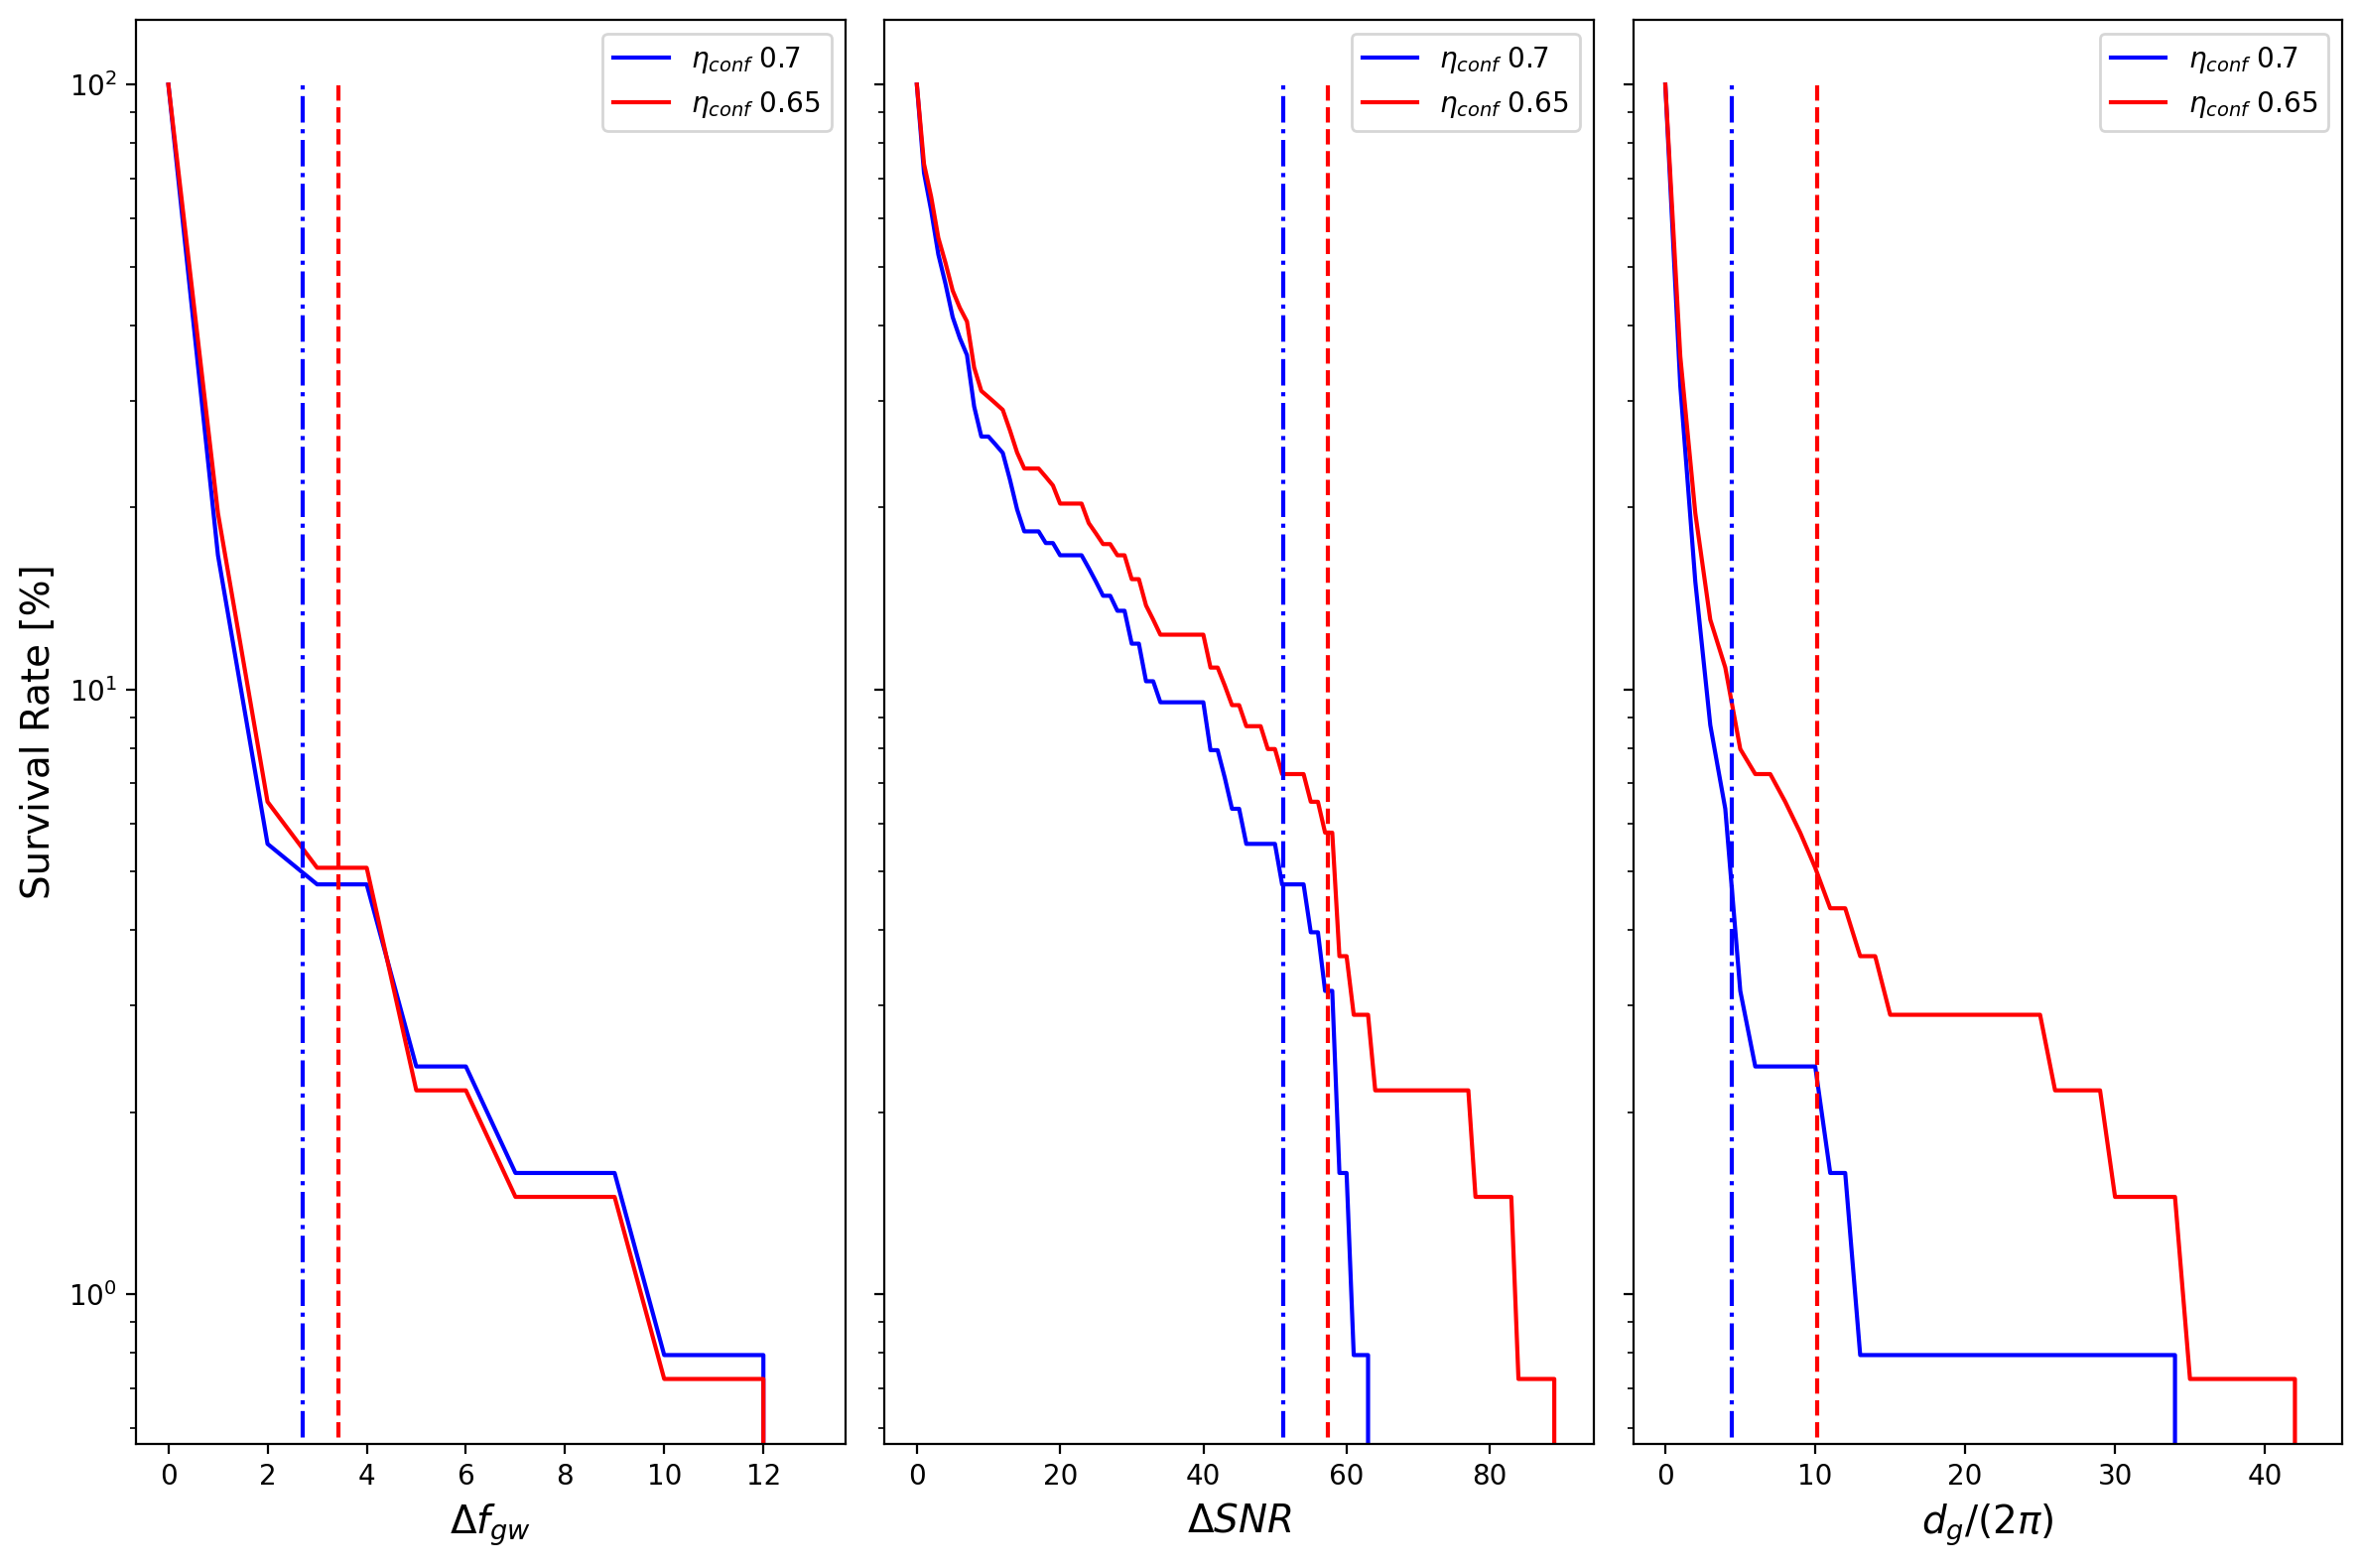

In [23]:
fig = plt.figure(figsize=(12,8), dpi=200)
ax1 = fig.add_subplot(1,3,1)
ax1.semilogy(freq_thresh1, freq_cross1,'b', label='$\eta_{conf}$ 0.7')
ax1.semilogy(freq_thresh2, freq_cross2,'r', label='$\eta_{conf}$ 0.65')
ax1.plot([freq_thresh_5_65, freq_thresh_5_65], [0, 100], 'r--')
ax1.plot([freq_thresh_5_70, freq_thresh_5_70], [0, 100], 'b-.')
ax1.legend(fontsize=10)
ax1.set_xlabel('$\Delta f_{gw}$', fontsize=14)
# ax1.set_title('Accumulative Freq. Error')
ax1.set_ylabel('Survival Rate [%]', fontsize=14)
ax1.label_outer()

ax2 = fig.add_subplot(1,3,2)
ax2.semilogy(snr_thresh1, snr_cross1,'b',label='$\eta_{conf}$ 0.7')
ax2.semilogy(snr_thresh2, snr_cross2,'r',label='$\eta_{conf}$ 0.65')
ax2.plot([snr_threshold_5_65, snr_threshold_5_65], [0, 100], 'r--')
ax2.plot([snr_threshold_5_70, snr_threshold_5_70], [0, 100], 'b-.')
ax2.legend(fontsize=10)
# ax2.set_title('Accumulative SNR')
ax2.set_xlabel('$\Delta SNR$',fontsize=14)
# ax2.set_ylabel('Fraction Above SNR Error [%]')
ax2.label_outer()

ax3 = fig.add_subplot(1,3,3)
ax3.semilogy(gc_thresh1, gc_cross1,'b',label='$\eta_{conf}$ 0.7')
ax3.semilogy(gc_thresh2, gc_cross2,'r',label='$\eta_{conf}$ 0.65')
ax3.plot([gc_thresh_5_65, gc_thresh_5_65], [0, 100], 'r--')
ax3.plot([gc_thresh_5_70, gc_thresh_5_70], [0, 100], 'b-.')
ax3.legend(fontsize=10)
# ax3.set_title('Accumulative Great Circle Error')
ax3.set_xlabel('$d_g/(2\pi)$', fontsize=14)
# ax3.set_ylabel('Fraction Above GC Error [%]')
ax3.label_outer()

plt.tight_layout()
# fig.savefig(estDir + 'fig/' + '/Stat_Acu' + dataset + '_id' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white')
fig.savefig(estDir + 'fig/' + '/Stat_Acu' + dataset + 'tSNR_' + str(tSNR_cut) + '_eSNR' + str(eSNR) + '_psrT_' + str(psr_t) + '.eps', dpi=300, facecolor='white', bbox_inches='tight')

In [ ]:
# plot accumulative errors: separate figs
fig1 = plt.figure(figsize=(8,4), dpi=200)
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(freq_thresh, freq_cross)
ax1.set_xlabel('Freq Error [%]')
ax1.set_title('Accumulative Freq. Error')
ax1.set_ylabel('Fraction Above Freq. Error [%]')
# fig1.savefig(estDir + 'fig/' + '/Freq_Acu' + dataset + '_id' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')
fig1.savefig(estDir + 'fig/' + '/Freq_Acu' + dataset + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')

fig2 = plt.figure(figsize=(8,4), dpi=200)
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(snr_thresh, snr_cross)
ax2.set_title('Accumulative SNR')
ax2.set_xlabel('SNR Error [%]')
ax2.set_ylabel('Fraction Above SNR Error [%]')
# fig2.savefig(estDir + 'fig/' + '/SNR_Acu' + dataset + '_id' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')
fig2.savefig(estDir + 'fig/' + '/SNR_Acu' + dataset + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')

fig3 = plt.figure(figsize=(8,4), dpi=200)
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(gc_thresh, gc_cross)
ax3.set_title('Accumulative Great Circle Error')
ax3.set_xlabel('Great Circle Error [%]')
ax3.set_ylabel('Fraction Above GC Error [%]')
# fig3.savefig(estDir + 'fig/' + '/GC_Acu' + dataset + '_id' + str(SNR_threshold) + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')
fig3.savefig(estDir + 'fig/' + '/GC_Acu' + dataset + 'tSNR_' + str(tSNR_cut) + '_psrT_' + str(psr_t) + '.png', dpi=300, facecolor='white', bbox_inches='tight')

## Noise distribution
*avgnoise* is a post-analysised data, which is carried from 50 realizations of noise only data. In each realization, 20 iterations of *ISIS* are run, and *avgnoise* is the average noise of 50 realizations of each iteration step.

In [ ]:
import seaborn as sns
import pandas as pd

sns.set(rc={'figure.dpi':300}) # set to default seaborn theme and change default image resolution to 300
# sns.axes_style() # print all the axes rc params

In [ ]:
fileName = 'noise'
noiseFile = loadmat('/Users/yiqianqian/Library/Mobile Documents/com~apple~CloudDocs/Research/PulsarTiming/SimDATA/MultiSource/Investigation/Final/noise/post_analysis/' + fileName + '.mat')
noise = noiseFile['avgnoise_tmp']
noise = noise.reshape((-1,1)).squeeze()
pd_noise = pd.DataFrame(noise,columns=["SNR"])
pd_noise.head(5)

In [ ]:
pd_noise.quantile(.95, interpolation='nearest')

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=200)
sns.histplot(pd_noise,x='SNR', kde=False, stat='density', bins=10)
fig.savefig('/Users/yiqianqian/Library/Mobile Documents/com~apple~CloudDocs/Research/PulsarTiming/SimDATA/MultiSource/Investigation/Final/noise/post_analysis/' + fileName + '.eps',format='eps', dpi=300, bbox_inches='tight')

In [ ]:
sns.displot(pd_noise,x='SNR', kind='ecdf', height=4, aspect=4/3)

In [ ]:
pd_noise[pd_noise['Noise'] > 7].shape[0]/pd_noise.shape[0]